In [ ]:
!pip install udocker==1.3.17 --quiet
!udocker --allow-root install
!pip install redisvl==0.3.7 --quiet
!pip install redis==5.2.1 --quiet
!pip install transformers==4.45.2 sentence-transformers==3.1.1 --quiet
!pip install datasets==3.1.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 10.4 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.17
Info: searching for udockertools >= 1.2.11
Info: installing udockertools 1.2.11
Info: installation of udockertools successful
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.0 MB/s eta 0:00:00
  

## Add the HF_TOKEN to colab secret for [huggingface](https://huggingface.co/)

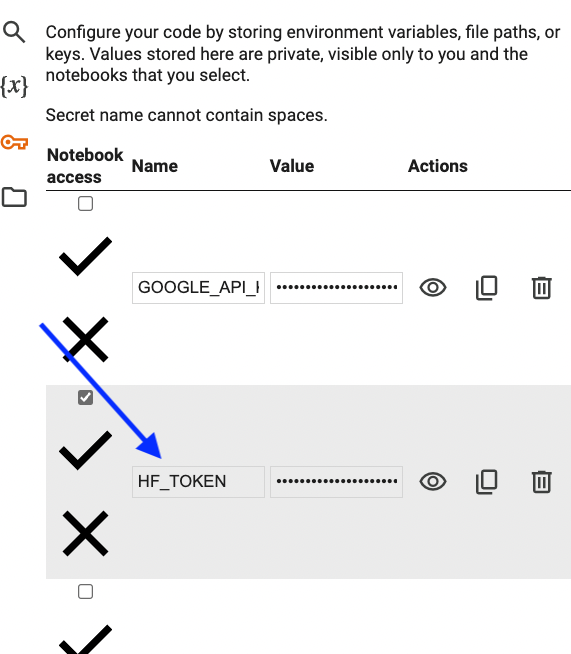

## Data preparation

In [ ]:
!wget https://raw.githubusercontent.com/reza-rahim/published/refs/heads/main/Fine_tuningEmbeddings/data/generated_qa_pairs_detail.csv

--2025-01-19 04:17:46--  https://raw.githubusercontent.com/reza-rahim/published/refs/heads/main/Fine_tuningEmbeddings/data/generated_qa_pairs_detail.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80469 (79K) [text/plain]
Saving to: ‘generated_qa_pairs_detail.csv’

generated_qa_pairs_ 100%[===================>]  78.58K  --.-KB/s    in 0.002s  

2025-01-19 04:17:46 (33.6 MB/s) - ‘generated_qa_pairs_detail.csv’ saved [80469/80469]



In [ ]:
!cat generated_qa_pairs_detail.csv |head -n 5

Question,Answer
What is the publication date of the NVIDIA Corporation Annual Report 2024?," The publication date of the NVIDIA Corporation Annual Report 2024 is February 21st, 2024."
What is the filing date of the 10-K report for NVIDIA Corporation in 2004?," The filing dates of the 10-K reports for NVIDIA Corporation in 2004 are May 20th, March 29th, and April 25th."
What is the purpose of the section of the filing that requires the registrant to indicate whether it has submitted electronically every Interactive Data File required to be submitted pursuant to Rule 405 of Regulation S-T?," The purpose of this section is to require the registrant to disclose whether it has submitted all required Interactive Data Files electronically, as mandated by Rule 405 of Regulation S-T, during the preceding 12 months or for the shorter period that the registrant was required to submit such files."
"What is the aggregate market value of the voting stock held by non-affiliates of the registrant as o

- load the ***generated_qa_pairs_detail.csv*** file into python dictionaty.

- set question as the key and answer as the value

In [ ]:
import csv
ind=0
# Open the CSV file
ind=0
qa_dict = {}
with open('generated_qa_pairs_detail.csv', mode='r') as file:
  csv_reader = csv.DictReader(file)
  for row in csv_reader:
        data = {"q": row['Question'], "a": (row['Answer'])}
        qa_dict[str(ind)] = data
        ind+=1


In [ ]:
qa_dict[str(0)]

{'q': 'What is the publication date of the NVIDIA Corporation Annual Report 2024?',
 'a': ' The publication date of the NVIDIA Corporation Annual Report 2024 is February 21st, 2024.'}

## Setting up ***Redis Vector Database*** with ***udocker***


For more information on ***Redis Vector Database***, please visit
- [Redis as a vector database quick start guide](https://redis.io/docs/latest/develop/get-started/vector-database/ )

- [Getting Started with RedisVL ](https://www.redisvl.com/user_guide/getting_started_01.html)

In [ ]:
!nohup udocker --allow-root run -p 6379:6379 redis/redis-stack-server &

nohup: appending output to 'nohup.out'


In [ ]:
%%sh

while true
do
  line=`ps -ef |grep redis | wc -l`
  if [ $line -eq 2 ]; then
    echo "Redis is running!"

    break
  fi
  sleep 5
  #echo "waiting for redis"
done


Redis is running!


In [ ]:
from redis import Redis
from redisvl.schema import IndexSchema
from redisvl.index import SearchIndex
import time

# Establish Redis connection and define index
client = Redis.from_url("redis://localhost:6379")

#Wait until the return is True
while(client.ping()):
  print("Redis is running!")
  break
else:
  print("Redis is not running!")
  time.sleep(1)

Redis is running!


Redis is running!


## Define ***NDCG*** formula

In [ ]:
import math

idcg=(3/math.log2(1+1)) + (2/math.log2(2+1)) + (1/math.log2(3+1))
ndcg=[0,0,0,0,0,0,0,0,0,0]
ndcg[0]=((3/math.log2(1+1)) + (0/math.log2(2+1)) + (0/math.log2(3+1)) + (0/math.log2(4+1))  + (0/math.log2(5+1)))/idcg
ndcg[1]=((0/math.log2(1+1)) + (2/math.log2(2+1)) + (0/math.log2(3+1)) + (0/math.log2(4+1))  + (0/math.log2(5+1)))/idcg
ndcg[2]=((0/math.log2(1+1)) + (0/math.log2(2+1)) + (2/math.log2(3+1)) + (0/math.log2(4+1))  + (0/math.log2(5+1)))/idcg
ndcg[3]=((0/math.log2(1+1)) + (0/math.log2(2+1)) + (0/math.log2(3+1)) + (1/math.log2(4+1))  + (0/math.log2(5+1)))/idcg
ndcg[4]=((0/math.log2(1+1)) + (0/math.log2(2+1)) + (0/math.log2(3+1)) + (0/math.log2(4+1))  + (1/math.log2(5+1)))/idcg

idcg,ndcg

(4.7618595071429155,
 [0.6300059872618923,
  0.26499301486112564,
  0.21000199575396408,
  0.09044293671986055,
  0.08123986158227729,
  0,
  0,
  0,
  0,
  0])

## Vector search and ***NDCG*** calculation with the vector search result





- Download ***bge base en model*** from ***Huggingface***

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses

model_id = "BAAI/bge-base-en-v1.5"

# Load a model
model = SentenceTransformer(
    model_id, device="cuda" if torch.cuda.is_available() else "cpu"
)

/usr/local/lib/python3.11/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


04:19:34 numexpr.utils INFO   NumExpr defaulting to 2 threads.
04:19:42 datasets INFO   PyTorch version 2.5.1+cu121 available.
04:19:42 datasets INFO   Polars version 1.9.0 available.
04:19:42 datasets INFO   Duckdb version 1.1.3 available.
04:19:42 datasets INFO   TensorFlow version 2.17.1 available.
04:19:42 datasets INFO   JAX version 0.4.33 available.
04:19:43 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


- Define a vector index in ***Redis*** named ***qa-idx*** using the [RedisVL](https://redis.io/docs/latest/integrate/redisvl/) client.


In [ ]:
# Create an IndexSchema object from a dictionary defining the schema for a QA index.
schema = IndexSchema.from_dict({
    # Top-level configuration of the index
    "index": {
        "name": "qa-idx",          # Name of the index
        "prefix": "qa",            # Prefix used for index identification
        "storage_type": "json"     # Type of storage for the index (JSON in this case)
    },
    # Definition of the fields in the index
    "fields": [
        {"name": "qa", "type": "tag"},  # A field named 'qa' used as a tag
        {
            "name": "embedding",         # A field for storing vector embeddings
            "type": "vector",            # The type is 'vector' for high-dimensional data
            "attrs": {
                "algorithm": "flat",          # The algorithm for indexing (flat in this case)
                "datatype": "float32",        # Data type of the vector elements
                "dims": 768,                  # Dimensionality of the vector
                "distance_metric": "l2"      # Distance metric used for comparisons (L2 norm)
            }
        }
    ]
})

- Create the qa-idx vector index.
- Generate embeddings for all the answers with ***bge base model***.
- Load the embeddings (vector representations) into the qa-idx vector index.

In [ ]:
# Create a search index in Redis using the specified schema and client
index = SearchIndex(schema, client)

# Attempt to delete the index if it already exists; otherwise, handle the exception gracefully
try:
    index.delete()
    print("recreating index")
except:
    print("Index not found, creating index")

# Create the index in Redis, overwriting it if it already exists
index.create(overwrite=True)

# Initialize a counter for assigning unique IDs to the QA data
ind = 0

# Iterate through the QA dictionary to process each key-value pair
for key in qa_dict:
    # Generate embeddings for the answer text using the model
    embeddings = model.encode(qa_dict[key]['a'], show_progress_bar=False)

    # Prepare the data for loading into the index, including a unique ID and the generated embeddings
    data = {"qa": "qa:" + str(ind), "embedding": embeddings.tolist()}

    # Load the prepared data into the index, specifying the unique ID field
    index.load([data], id_field="qa")

    # Increment the counter for the next QA pair
    ind += 1


Index not found, creating index


- Perform a vector search for each question and retrieve the top 10 answers  from Redis.
- Determine the position of the actual answer for the given question in the returned list.
- Compute the NDCG score based on the position of the actual answer.


In [ ]:
# Import the VectorQuery class to perform vector-based searches in Redis
from redisvl.query import VectorQuery

# Initialize variables for tracking metrics
total_ndcg = 0            # Cumulative NDCG score across all queries
total_cnt = 0             # Total number of questions processed
match_cnt = 0             # Total number of questions with a correct match
match_place = [0] * 10    # Array to track how often the actual answer is found at each position (0-9)

# Iterate through the QA dictionary to process each question
for key in qa_dict:
    # Generate embeddings for the current question
    embeddings = model.encode(qa_dict[key]['q'], show_progress_bar=False)

    # Define a vector query to search for the top 5 most similar answers
    query = VectorQuery(
        vector=embeddings.tolist(),       # The embedding vector of the question
        vector_field_name="embedding",    # Field name in the Redis index for vector data
        num_results=5                     # Number of results to retrieve
    )

    # Execute the query and get the results from the index
    results = index.query(query)

    # Initialize an index for ranking positions in the result list
    idx = 0

    # Iterate through the query results to locate the position of the actual answer
    for result in results:
        # Check if the result ID matches the actual answer's key
        if (result['id'].split(":"))[2] == str(key):
            match_place[idx] += 1               # Increment the counter for the matched position
            total_ndcg += ndcg[idx]            # Add the NDCG score for this position
            match_cnt += 1                     # Increment the match count
        idx += 1                               # Move to the next position in the result list

    # Increment the total count of processed questions
    total_cnt += 1

# Print the final metrics
print(f"total_ndcg: {total_ndcg}, total_cnt: {total_cnt}")
print(f"match_place: {match_place}, match_cnt: {match_cnt}")
print(f"total_ndcg/total_cnt: {total_ndcg/total_cnt}")

total_ndcg: 87.2980074947343, total_cnt: 178
match_place: [132, 8, 5, 8, 3, 0, 0, 0, 0, 0], match_cnt: 156
total_ndcg/total_cnt: 0.49043824435243993


- Download the ***bge finetuned*** model from Huggingface

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses

model_id_finetune = "rezarahim/bge-finetuned-detail"

# Load a model
model_finetune  = SentenceTransformer(
    model_id_finetune, device="cuda" if torch.cuda.is_available() else "cpu"
)

04:22:08 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: rezarahim/bge-finetuned-detail


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]


- Define a vector index in ***Redis*** named ***qa-idx-finetune*** using the [RedisVL](https://redis.io/docs/latest/integrate/redisvl/) client.

In [ ]:
# Define a schema for a fine-tuned QA vector index in Redis
schema_finetune = IndexSchema.from_dict({
    # Configuration of the index metadata
    "index": {
        "name": "qa-idx-finetune",      # Name of the fine-tuned index
        "prefix": "qa-finetune",       # Prefix used for identifying keys in the index
        "storage_type": "json"         # Specifies that the index uses JSON for storage
    },
    # Define the fields for the index
    "fields": [
        {"name": "qa", "type": "tag"},  # A field named 'qa' for storing tags
        {
            "name": "embedding",        # A field for storing vector embeddings
            "type": "vector",           # The type is 'vector' for high-dimensional data
            "attrs": {
                "algorithm": "flat",         # Specifies the indexing algorithm (flat in this case)
                "datatype": "float32",       # Data type of the vector elements
                "dims": 768,                 # Dimensionality of the vector embeddings
                "distance_metric": "l2"     # Distance metric used for similarity (L2 norm)
            }
        }
    ]
})

In [ ]:
# Create a search index for the fine-tuned model using the specified schema and client
index_finetune = SearchIndex(schema_finetune, client)

# Attempt to delete the existing index if it already exists; handle the exception if the index is not found
try:
    index_finetune.delete()  # Delete the existing index
    print("Recreating index")  # Log the recreation of the index
except:
    print("Index not found, creating index")  # Log the creation of a new index

# Create the index in Redis, overwriting it if it already exists
index_finetune.create(overwrite=True)

# Initialize a counter to assign unique IDs to the QA data
ind = 0

# Iterate through the QA dictionary to process each key-value pair
for key in qa_dict:
    # Generate fine-tuned embeddings for the answer text using the fine-tuned model
    embeddings = model_finetune.encode(qa_dict[key]['a'], show_progress_bar=False)

    # Prepare the data for loading into the index, including a unique ID and the generated embeddings
    data = {"qa": "qa:" + str(ind), "embedding": embeddings.tolist()}

    # Load the prepared data into the fine-tuned index, specifying the unique ID field
    index_finetune.load([data], id_field="qa")

    # Increment the counter for the next QA pair
    ind += 1


Recreating index


In [ ]:
from redisvl.query import VectorQuery

total_ndcg=0;
total_cnt=0;
match_cnt=0;
match_place=[0,0,0,0,0,0,0,0,0,0];

for key in qa_dict:
    #print(f"key: {key}")
    embeddings=model_finetune.encode(qa_dict[key]['q'],show_progress_bar=False)
    query = VectorQuery(
    vector=embeddings.tolist(),
      vector_field_name="embedding",
      num_results=10
    )

    results = index_finetune.query(query)
    idx=0
    for result in results:
      #print((result['id'].split(":"))[2])
      if (result['id'].split(":"))[2] == str(key):
          #print(f"match_place: {match_place}")
          match_place[idx]+=1
          total_ndcg+=(ndcg[idx])
          match_cnt+=1
      idx=idx+1
    total_cnt+=1;

print(f"total_ndcg: {total_ndcg}, total_cnt: {total_cnt}")
print(f"match_place: {match_place}, match_cnt {match_cnt}")
print(f"total_ndcg/total_cnt: {total_ndcg/total_cnt}")`

total_ndcg: 107.30182786931084, total_cnt: 178
match_place: [166, 8, 2, 2, 0, 0, 0, 0, 0, 0], match_cnt 178
total_ndcg/total_cnt: 0.6028192576927576
